# 1. Open data

In [1]:
import os
import re


class OpenData(object):

    def __init__(self, path) -> None:
        self.path = path

    def check_filename_format(self, filename):
        # Регулярное выражение для проверки формата
        pattern = re.compile(r'^[A-Za-z0-9]+_[A-Za-z0-9.]+_\d{2}\.\d{2}\.\d{4}\.xlsx$')

        # Проверка соответствия формату
        if pattern.match(filename):
            return True
        else:
            return False

    def readFiles(self):
        files = {}
        for file in os.listdir(self.path):
            if "xlsx" in file:
                files[file] = self.path+'\\'+file

        return files

In [6]:
dt = OpenData(path = 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data')
files = dt.readFiles()
files

{'BsAb_EG.5_05.05.2025.xlsx': 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data\\BsAb_EG.5_05.05.2025.xlsx',
 'BsAb_EG.5_21.03.2025.xlsx': 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data\\BsAb_EG.5_21.03.2025.xlsx',
 'BsAb_EG.5_III_04.12.2024.xlsx': 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data\\BsAb_EG.5_III_04.12.2024.xlsx',
 'BsAb_EG.5_II_04.12.2024.xlsx': 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data\\BsAb_EG.5_II_04.12.2024.xlsx',
 'BsAb_EG.5_I_04.12.2024.xlsx': 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data\\BsAb_EG.5_I_04.12.2024.xlsx',
 'BsAb_JN.1_04.12.2024.xlsx': 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data\\BsAb_JN.1_04.12.2024.xlsx',
 'BsAb_JN.1_05.05.2025.xlsx': 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data\\BsAb_JN.1_05.05.2025.xlsx',
 'BsAb_JN.1_05.12.2024.xlsx': 'C:\\Users\\Professional\\Documents\\VirusNeutr\\all_infected_data\\Bs

# 2. Preparing & merging data
### here you can add your implementation

In [7]:
import pandas as pd
from datetime import datetime

class MergeData(object):

    def __init__(self, files):
        self.file = files

    def openDataFrames(self, files):
        self.dataframes = {}
        for key, value in files.items():
            self.dataframes[key] = pd.read_excel(value)
            self.dataframes[key].columns =  self.dataframes[key].columns.astype(str)

    def parseDataColumns(self):
        for key, value in self.dataframes.items():
            new_cols = {}
            for col in value.columns:
                if '-tetra' in col:
                    new_col = col.replace('tetra', 'Gs')
                    if '-Fc' in col:
                        new_col = new_col.replace('-Fc', '')
                    new_cols[col] = new_col
            if len(new_cols) > 0:
                self.dataframes[key] = value.rename(columns = new_cols)

        for key, value in self.dataframes.items():
            new_cols = {}
            for col in value.columns:
                if '-bis' in col:
                    new_col = col.replace('-bis', '')
                    new_cols[col] = new_col
            if len(new_cols) > 0:
                self.dataframes[key] = value.rename(columns = new_cols)

        for key, value in self.dataframes.items():
            new_cols = {}
            for col in value.columns:
                if 'Gs' not in col:
                    if '58-57' in col:
                        new_col = col.replace('58-57', '57-58')
                        new_cols[col] = new_col
                    if '57-21' in col:
                        new_col = col.replace('57-21', '21-57')
                        new_cols[col] = new_col
                    if '57-7' in col:
                        new_col = col.replace('57-7', '7-57')
                        new_cols[col] = new_col
                    if '21-7' in col:
                        new_col = col.replace('21-7', '7-21')
                        new_cols[col] = new_col
                    if '58-7' in col:
                        new_col = col.replace('58-7', '7-58')
                        new_cols[col] = new_col
                    if '58-21' in col:
                        new_col = col.replace('58-21', '21-58')
                        new_cols[col] = new_col

                
            if len(new_cols) > 0:
                self.dataframes[key] = value.rename(columns = new_cols)
    
    def parseFileNames(self):
        self.names = {}
        for key in self.dataframes.keys():
            self.names[key] = key.replace('BsAb_', '').replace('mono_', '').replace('homo_', '').replace('_', ' ').replace('.xlsx', '')

    def process_dict(self, data):
        df = pd.DataFrame(columns=['serum', 'date'])

        for key, value in data.items():
            parts = value.split(' ')

            date = parts[-1]

            virus = ' '.join(parts[:-1])

            if ' III' in virus:
                virus = virus.replace(' III', '')

            if ' II' in virus:
                virus = virus.replace(' II', '')

            if ' I' in virus:
                virus = virus.replace(' I', '')

            df.loc[key] = [virus, date]

        return df
    
    def parseMultipleDfs(self, dfs):
        parsedDfs = []
        for name, df in dfs.items():
            for col in df.columns:
                if "." in col:
                    spl_col = col.split(".")[0]
                    df[spl_col] = (df[spl_col] + df[col]) / 2
                    df = df.drop(columns = [col])
            parsedDfs.append(self.parseDf(df, name))

        return pd.concat(parsedDfs, axis=0, ignore_index=True)

    def  parseDf(self, df, name):
        dfs = []
        for col in df.columns:
            if col != 'X':
                dfs.append(self.createDfPerColumn(df[col], col, df['X'], name))

        return pd.concat(dfs, axis=0, ignore_index=True)

    def createDfPerColumn(self, df_col, col_name, x_col, virus):
        return pd.DataFrame(data={
            'virus': [col_name for _ in range(len(df_col))],
            'serum': [virus for _ in range(len(df_col))],
            'replicate': [1 for _ in range(len(df_col))],
            'concentration': x_col.values,
            'fraction infectivity': df_col.values,
        })
    
    def processViruses(self, dataframe, parsedVirusNames):
        dataframe = dataframe.merge(parsedVirusNames, left_on='serum', right_index=True, suffixes=('', '_new'))
        dataframe['serum'] = dataframe['serum_new']
        dataframe.drop(columns=['serum_new'], inplace=True)
        return dataframe
    
    def generate_process_combinations(self, dataframe):
        combinations = []
        for i in range(len(dataframe)):
            combinations.append((dataframe.loc[i, 'serum'], dataframe.loc[i, 'virus']))
        
        self.combinations = list(set(combinations))

    def create_serum_virus_dict(self, dataframe):
        serum_virus_dict = {}
        for _, row in dataframe.iterrows():
            serum = row['serum']
            virus = row['virus']
            if serum not in serum_virus_dict:
                serum_virus_dict[serum] = {}
            serum_virus_dict[serum][virus] = True
        return serum_virus_dict

    def process_replicates(self, dataframe):
        dct = {}

        for combo in self.combinations:
            if len(set(dataframe[(dataframe['serum'] == combo[0]) & (dataframe['virus'] == combo[1])]['date'].values)) > 1:
                date_objects = [datetime.strptime(date, '%d.%m.%Y') for date in list(set(dataframe[(dataframe['serum'] == combo[0]) & (dataframe['virus'] == combo[1])]['date'].values))]
                sorted_dates = sorted(date_objects)
                numbered_dates = {date.strftime('%d.%m.%Y'): i + 1 for i, date in enumerate(sorted_dates)}
                for key, val in numbered_dates.items():
                    dct[(combo[0], combo[1], key)] = val

        print(dct)

        for key, value in dct.items():
            for idx in dataframe[(dataframe['serum'] == key[0]) & (dataframe['virus'] == key[1]) & (dataframe['date'] == key[2])].index:
                dataframe.loc[idx, 'replicate'] = int(value)
    


dt = MergeData(files=files)
dt.openDataFrames(files=files)
dt.parseDataColumns()
dt.parseFileNames()
new_virus_names = dt.process_dict(data=dt.names)
merged_data = dt.parseMultipleDfs(dt.dataframes)
df = dt.processViruses(merged_data, new_virus_names)
dt.generate_process_combinations(df)
dt.process_replicates(df)

serum_virus_dict = dt.create_serum_virus_dict(df)

{('JN.1', 'SA55', '06.12.2024'): 1, ('JN.1', 'SA55', '05.05.2025'): 2, ('KP.2', 'B7+A57', '28.11.2024'): 1, ('KP.2', 'B7+A57', '29.11.2024'): 2, ('KP.2', 'SA55', '29.11.2024'): 1, ('KP.2', 'SA55', '05.05.2025'): 2, ('KP.3.1.1', '58-35-L15H', '14.03.2025'): 1, ('KP.3.1.1', '58-35-L15H', '05.05.2025'): 2, ('EG.5', '58-35-L15H', '21.03.2025'): 1, ('EG.5', '58-35-L15H', '05.05.2025'): 2, ('KP.3.1.1', '7-35-L15H', '14.03.2025'): 1, ('KP.3.1.1', '7-35-L15H', '05.05.2025'): 2, ('KP.2', 'A7+B58', '28.11.2024'): 1, ('KP.2', 'A7+B58', '29.11.2024'): 2, ('EG.5', '7-35-L15H', '21.03.2025'): 1, ('EG.5', '7-35-L15H', '05.05.2025'): 2, ('EG.5', '57-35-L15H', '21.03.2025'): 1, ('EG.5', '57-35-L15H', '05.05.2025'): 2, ('EG.5', 'SA55', '04.12.2024'): 1, ('EG.5', 'SA55', '05.05.2025'): 2}


In [8]:
df

,virus,serum,replicate,concentration,fraction infectivity,date
0,7-35-L15H,EG.5,2,8000.0000,5.234200,05.05.2025
1,7-35-L15H,EG.5,2,2666.6667,5.661600,05.05.2025
2,7-35-L15H,EG.5,2,888.8889,5.029700,05.05.2025
3,7-35-L15H,EG.5,2,296.2963,5.065500,05.05.2025
4,7-35-L15H,EG.5,2,98.7654,7.058500,05.05.2025
...,...,...,...,...,...,...
1295,7-35-L15H,XEC,1,32.9218,18.404007,05.05.2025
1296,7-35-L15H,XEC,1,10.9739,19.859131,05.05.2025
1297,7-35-L15H,XEC,1,3.6580,21.734659,05.05.2025
1298,7-35-L15H,XEC,1,1.2193,20.081390,05.05.2025


## serum_virus_dict is a config file in which should be viruses & antibodies to plot. If True class will plot Hill curve, if False - curve won't be vizualised.

In [10]:
serum_virus_dict

{'EG.5': {'7-35-L15H': True,
  '57-35-L15H': True,
  '58-35-L15H': True,
  '57-18-7-Fc': True,
  '58-18-7-Fc': True,
  'SA55': True,
  '57-35-58': True,
  'A57+B58': True,
  '58-18-7': True,
  '58-35-7': True,
  '57-35-7': True,
  '58-Fc': True,
  '80-35-7': True,
  'A7+B58': True,
  'B7+A57': True,
  '58-18-57': True,
  '58-35-57': True,
  '7-35-57': True,
  '7-18-57': True,
  '57-18-7': True,
  '57-18-58': True,
  '7-Fc': True,
  '7-18-57-Fc': True,
  '58-18-57-Fc': True,
  '7-35-57-Fc': True,
  '58-35-57-Fc': True,
  '58-N-57': True,
  '58-H2-57': True,
  '58-10-57': True},
 'JN.1': {'7-18-57-Fc': True,
  '58-18-57-Fc': True,
  '7-35-57-Fc': True,
  '58-35-57-Fc': True,
  '58-N-57': True,
  '58-H2-57': True,
  '58-10-57': True,
  '58-18-57': True,
  '7-35-L15H': True,
  '57-35-L15H': True,
  '58-35-L15H': True,
  '57-18-7-Fc': True,
  '58-18-7-Fc': True,
  'SA55': True,
  '58-35-57': True,
  '7-35-57': True,
  '7-18-57': True,
  '57-18-7': True,
  '57-18-58': True,
  '80-35-7': True

# 3. Plot data

In [9]:
import neutcurve
import matplotlib.pyplot as plt
import numpy as np
import plotly.tools as tls
import plotly.graph_objects as go

class PlotData(object):

    def __init__(self, params):
        self.params = params

    def createHillCurvePlot(
        self,
        parsed_dataframe, 
        ):
        fits = neutcurve.CurveFits(
            parsed_dataframe, 
            fix_slope_first=False,
            allow_reps_unequal_conc=True,
            fixbottom=0,
            fixtop=100,
            infectivity_or_neutralized=self.params['infectivity_or_neutralized'],
            )
        fit_params = fits.fitParams(average_only=self.params['average_only'], no_average=self.params['no_average'], ic50_error="fit_stdev")
        fig, axs = fits.plotSera(
            xlabel="", 
            ylabel="", 
            ncol=self.params['ncol'],
            max_viruses_per_subplot=len(set(parsed_dataframe['virus'].values)),
            virus_to_color_marker = self.params['markers_colors_dict'],
            markersize = self.params['marker_size_px'],
            linewidth=self.params['marker_line_px'],
            legendtitle='',
            orderlegend=None,
            titlesize=self.params['subplot_title_fontsize'],
            labelsize=25,
            ticksize=20,
            legendfontsize=0,
            sharex=False,
            sharey=False,
            fix_lims=self.params['fix_lims'],
        )

        handles, labels = [], []

        for ax in axs:
            for i in ax:
                # i.set_xticklabels(xticklabels, fontdict={'family': self.params['font'], 'size': self.params['ylabel_fontsize']})
                i.xaxis.set_tick_params(labelsize=self.params['xlabel_fontsize'])
                i.yaxis.set_tick_params(labelsize=self.params['ylabel_fontsize'])
                i.grid(True, color='gray', linestyle='-', linewidth=2, alpha=0.5)
                i.set_facecolor('white')
                i.set_title(i.get_title(), fontdict={'family': self.params['font'], 'size': self.params['subplot_title_fontsize'], 'fontweight': 'bold'})
                pos = i.get_position()
                width = pos.width * 1.1
                i.set_position([pos.x0, pos.y0, width, pos.height])
                i.set_xlabel(self.params['xtitle'], labelpad=self.params['xlabel_pad'], fontdict={'family': self.params['font'], 'size': self.params['xlabel_title_fontsize']})
                i.set_ylabel(self.params['ytitle'], labelpad=self.params['ylabel_pad'], fontdict={'family': self.params['font'], 'size': self.params['ylabel_title_fontsize']})
                handles.append(i.get_legend_handles_labels()[0])
                labels.append(i.get_legend_handles_labels()[1])

                lines = i.get_lines()
                for j in range(len(lines)):
                    lines[j].set_markeredgecolor('black')
                    lines[j].set_markeredgewidth(1)
                    # TODO
                    # lines[j].set_alpha(0.7)  # Установите прозрачность линии
                    # lines[j].set_markerfacecolor((1, 1, 1, 0.5))  # Установите прозрачность маркера

                i.legend([], [], frameon=False) 

                i.xaxis.set_label_coords(self.params['xaxis_coords'][0], self.params['xaxis_coords'][1])
                i.yaxis.set_label_coords(self.params['yaxis_coords'][0], self.params['yaxis_coords'][1])

        fig.subplots_adjust(wspace=self.params['wspace'], hspace=self.params['hspace'], bottom=self.params['bottom_padding'])

        return fig, axs, handles, labels, fit_params
    
    # Функция для удаления строк, где комбинация serum:virus равна False
    def filter_dataframe(self, parsed_dataframe, serum_virus_dict):
        filtered_df = parsed_dataframe[parsed_dataframe.apply(lambda row: serum_virus_dict.get(row['serum'], {}).get(row['virus'], False), axis=1)]
        return filtered_df
    
    def scale_to_percentage(self, arr):
        # Проверка, что минимальное значение меньше максимального
        min_val, max_val = min(arr), max(arr)
        for i in range(len(arr)):
            arr[i] = arr[i] - min_val
        percent = (max_val - min_val) / 100
        for i in range(len(arr)):
            arr[i] = arr[i] / percent

        return arr
    
    def plotData(
            self,
            parsed_dataframe,
            ):
        
        parsed_dataframe = self.filter_dataframe(parsed_dataframe, self.params['serum_virus_dict'])
        
        if self.params['scale']:
            for virus in set(parsed_dataframe['serum']):
                for serum in set(parsed_dataframe[parsed_dataframe['serum'] == virus]['virus']):
                    for replicate in set(parsed_dataframe[(parsed_dataframe['serum'] == virus) & (parsed_dataframe['virus'] == serum)].replicate):
                        modified = self.scale_to_percentage(parsed_dataframe[(parsed_dataframe['serum'] == virus) & (parsed_dataframe['virus'] == serum) & (parsed_dataframe['replicate'] == replicate)]["fraction infectivity"].values)
                        i = 0
                        for idx in parsed_dataframe[(parsed_dataframe['serum'] == virus) & (parsed_dataframe['virus'] == serum) & (parsed_dataframe['replicate'] == replicate)].index:
                            parsed_dataframe.loc[idx, "fraction infectivity"] = modified[i]
                            i += 1

        if self.params['reverse']:
            parsed_dataframe['fraction infectivity'] = 100 - parsed_dataframe['fraction infectivity']
            parsed_dataframe.loc[parsed_dataframe[parsed_dataframe['fraction infectivity'] < 0].index, 'fraction infectivity'] = 0
        
        fig, ax, handles, labels, fit_params = self.createHillCurvePlot(parsed_dataframe)
        fig.set_size_inches(self.params['fheight'], self.params['fwidth'])
        title = fig.suptitle(self.params['title'], fontdict={'family': self.params['font']}, fontsize=self.params['title_fontsize'], fontweight='bold', y=1.02)

        if self.params['common_legend']:
            # Создание общей легенды для всех подграфиков
            handles = []
            labels = []
            for name, (color, marker) in self.params['markers_colors_dict'].items():
                handle = plt.Line2D([0, 0], [0, 0], marker=marker, color=color, linestyle='')
                handles.append(handle)
                labels.append(name)

            # Изменение параметров легенды
            legend = fig.legend(
                handles, labels, 
                loc='lower center', 
                ncol=self.params['legend_ncols'], 
                markerscale=self.params['marker_size'], 
                prop={'family': self.params['font'], 'size': self.params['legend_fontsize']},
                borderaxespad=self.params['legend_borderaxespad'])
            legend.get_frame().set_linewidth(0.0)  # Убираем рамку вокруг легенды

            # Добавление обводки к маркерам легенды
            for handle in legend.legendHandles:
                handle.set_markeredgecolor('black')  # Задаем цвет обводки
                handle.set_markeredgewidth(self.params['marker_line_width'])  # Задаем толщину обводки

        # Изменение расстояния от заголовка до графиков
        fig.subplots_adjust(top=self.params['title_padding'])  # Задаем нужное расстояние с помощью параметра top
        title.set_position((0.5, 1.02))

        return fig, ax, parsed_dataframe, fit_params
    
    def calculate_std_dev(self, parsed_dataframe):
        std_dev_data = []

        for virus in set(parsed_dataframe['serum']):
            for serum in set(parsed_dataframe[parsed_dataframe['serum'] == virus]['virus']):
                replications = parsed_dataframe[(parsed_dataframe['serum'] == virus) & (parsed_dataframe['virus'] == serum)]
                std_dev = replications['fraction infectivity'].std()
                mean_infectivity = replications['fraction infectivity'].mean()
                std_dev_data.append({
                    'serum': virus,
                    'virus': serum,
                    'mean_infectivity': mean_infectivity,
                    'std_dev': std_dev
                })

        std_dev_df = pd.DataFrame(std_dev_data)
        return std_dev_df
    
    def plotData_plotly(
            self,
            parsed_dataframe,
            fheight=36,  # Высота фигуры в дюймах
            fwidth=18,  # Ширина фигуры в дюймах
            font="Arial",  # Шрифт для текста на графиках
            markers_colors_dict=None,  # Словарь, содержащий маркеры и цвета для каждого вируса
            title='BsAb neutrolizing values',  # Заголовок графика
            marker_size=5.,
            marker_size_px=20,  # Размер маркеров в пикселях
            marker_line_px=5,  # Ширина линии маркеров в пикселях
            marker_line_width=1.,
            xaxis_coords=(0.5, -0.13),  # Координаты для размещения подписи оси X
            yaxis_coords=(-0.09, 0.5),  # Координаты для размещения подписи оси Y
            xlabel_title_fontsize=35,  # Размер шрифта для подписи оси X
            ylabel_title_fontsize=35,  # Размер шрифта для подписи оси Y
            xlabel_fontsize=35,  # Размер шрифта для меток на оси X
            ylabel_fontsize=35,  # Размер шрифта для меток на оси Y
            xlabel_pad=35,  # Отступ подписи оси X от оси
            ylabel_pad=35,  # Отступ подписи оси Y от оси
            subplot_title_fontsize=45,  # Размер шрифта для заголовков подграфиков
            title_fontsize=55,  # Размер шрифта для общего заголовка графика
            title_padding=0.92,  # Отступ общего заголовка от верхней границы фигуры
            bottom_padding=0.16,
            legend_fontsize=30,  # Размер шрифта для легенды
            legend_borderaxespad=0,  # Отступ легенды от границы фигуры
            legend_ncols=5,  # Количество столбцов в легенде
            xtitle='[Ab] нг/мл',  # Подпись оси X
            ytitle='Уровень нейтрализации, %',  # Подпись оси Y
            wspace=0.2, # расстояние между графиками по горизонтали в масштабе
            hspace=0.39, # расстояние между графиками по вертикали в масштабе
            ncol=4,  # параметр для управления количеством столбцов
            fix_lims={
                'ymin': -5,
                'ymax': 110,
            },
            average_only=True,
            no_average=False,
            scale=True,
            reverse=True,
            infectivity_or_neutralized='neutralized',
            serum_virus_dict=None,
            ):

        parsed_dataframe = self.filter_dataframe(parsed_dataframe, serum_virus_dict)

        if scale:
            for virus in set(parsed_dataframe['serum']):
                for serum in set(parsed_dataframe[parsed_dataframe['serum'] == virus]['virus']):
                    for replicate in set(parsed_dataframe[(parsed_dataframe['serum'] == virus) & (parsed_dataframe['virus'] == serum)].replicate):
                        modified = self.scale_to_percentage(parsed_dataframe[(parsed_dataframe['serum'] == virus) & (parsed_dataframe['virus'] == serum) & (parsed_dataframe['replicate'] == replicate)]["fraction infectivity"].values)
                        i = 0
                        for idx in parsed_dataframe[(parsed_dataframe['serum'] == virus) & (parsed_dataframe['virus'] == serum) & (parsed_dataframe['replicate'] == replicate)].index:
                            parsed_dataframe.loc[idx, "fraction infectivity"] = modified[i]
                            i += 1

        if reverse:
            parsed_dataframe['fraction infectivity'] = 100 - parsed_dataframe['fraction infectivity']
            parsed_dataframe.loc[parsed_dataframe[parsed_dataframe['fraction infectivity'] < 0].index, 'fraction infectivity'] = 0

        # Расчет стандартного отклонения
        std_dev_df = self.calculate_std_dev(parsed_dataframe)

        # Создание фигуры Plotly
        fig = go.Figure()

        # Добавление данных на график
        for virus in set(parsed_dataframe['serum']):
            for serum in set(parsed_dataframe[parsed_dataframe['serum'] == virus]['virus']):
                subset = parsed_dataframe[(parsed_dataframe['serum'] == virus) & (parsed_dataframe['virus'] == serum)]
                std_dev_row = std_dev_df[(std_dev_df['serum'] == virus) & (std_dev_df['virus'] == serum)]
                color, marker = markers_colors_dict[virus]

                # Преобразование маркеров Matplotlib в маркеры Plotly
                plotly_marker = {
                    'o': 'circle',
                    's': 'square',
                    'P': 'pentagon',
                    'D': 'diamond'
                }.get(marker, 'circle')

                fig.add_trace(go.Scatter(
                    x=subset['concentration'],  # Замените на вашу колонку X
                    y=subset['fraction infectivity'],
                    mode='markers',
                    marker=dict(
                        color=color,
                        symbol=plotly_marker,
                        size=marker_size_px,
                        line=dict(color='black', width=marker_line_width)
                    ),
                    name=f'{virus} {serum}',
                    error_y=dict(
                        type='data',
                        array=std_dev_row['std_dev'].values,  # Стандартное отклонение
                        visible=True
                    )
                ))

        # Настройка заголовка
        fig.update_layout(
            title=dict(
                text=title,
                font=dict(family=font, size=title_fontsize, color='black'),
                x=0.5,
                y=1.0,  # Исправлено значение y
                xanchor='center',
                yanchor='top'
            ),
            height=fheight * 96,  # Перевод из дюймов в пиксели
            width=fwidth * 96,  # Перевод из дюймов в пиксели
            legend=dict(
                x=0.5,
                y=-0.1,
                xanchor='center',
                yanchor='top',
                orientation='h',
                itemsizing='constant',
                font=dict(family=font, size=legend_fontsize),
                borderwidth=0
            ),
            margin=dict(t=title_padding * 100)  # Перевод в проценты
        )

        # Настройка шкал X и Y
        fig.update_xaxes(title_text=xtitle, title_font=dict(size=xlabel_title_fontsize), tickfont=dict(size=xlabel_fontsize))
        fig.update_yaxes(title_text=ytitle, title_font=dict(size=ylabel_title_fontsize), tickfont=dict(size=ylabel_fontsize))

        return fig, parsed_dataframe

In [14]:
for virus, abs in serum_virus_dict.items():
    for ab, display in abs.items():
            serum_virus_dict[virus][ab] = False 

serum_virus_dict

{'EG.5': {'7-35-L15H': False,
  '57-35-L15H': False,
  '58-35-L15H': False,
  '57-18-7-Fc': False,
  '58-18-7-Fc': False,
  'SA55': False,
  '57-35-58': False,
  'A57+B58': False,
  '58-18-7': False,
  '58-35-7': False,
  '57-35-7': False,
  '58-Fc': False,
  '80-35-7': False,
  'A7+B58': False,
  'B7+A57': False,
  '58-18-57': False,
  '58-35-57': False,
  '7-35-57': False,
  '7-18-57': False,
  '57-18-7': False,
  '57-18-58': False,
  '7-Fc': False,
  '7-18-57-Fc': False,
  '58-18-57-Fc': False,
  '7-35-57-Fc': False,
  '58-35-57-Fc': False,
  '58-N-57': False,
  '58-H2-57': False,
  '58-10-57': False},
 'JN.1': {'7-18-57-Fc': False,
  '58-18-57-Fc': False,
  '7-35-57-Fc': False,
  '58-35-57-Fc': False,
  '58-N-57': False,
  '58-H2-57': False,
  '58-10-57': False,
  '58-18-57': False,
  '7-35-L15H': False,
  '57-35-L15H': False,
  '58-35-L15H': False,
  '57-18-7-Fc': False,
  '58-18-7-Fc': False,
  'SA55': False,
  '58-35-57': False,
  '7-35-57': False,
  '7-18-57': False,
  '57-18-7

In [15]:
serum_virus_dict['EG.5']['58-35-57-Fc'] = True
serum_virus_dict['EG.5']['7-35-57-Fc'] = True
serum_virus_dict['EG.5']['58-18-57-Fc'] = True
serum_virus_dict['EG.5']['7-18-57-Fc'] = True
serum_virus_dict['EG.5']['57-18-7-Fc'] = True
serum_virus_dict['EG.5']['58-18-7-Fc'] = True
serum_virus_dict['EG.5']['58-Fc'] = True
serum_virus_dict['EG.5']['7-Fc'] = True
serum_virus_dict['EG.5']['SA55'] = True

serum_virus_dict['JN.1']['58-35-57-Fc'] = True
serum_virus_dict['JN.1']['7-35-57-Fc'] = True
serum_virus_dict['JN.1']['58-18-57-Fc'] = True
serum_virus_dict['JN.1']['7-18-57-Fc'] = True
serum_virus_dict['JN.1']['57-18-7-Fc'] = True
serum_virus_dict['JN.1']['58-18-7-Fc'] = True
serum_virus_dict['JN.1']['58-Fc'] = True
serum_virus_dict['JN.1']['57-Fc'] = True
serum_virus_dict['JN.1']['7-Fc'] = True
serum_virus_dict['JN.1']['SA55'] = True

serum_virus_dict['KP.2']['58-35-57-Fc'] = True
serum_virus_dict['KP.2']['7-35-57-Fc'] = True
serum_virus_dict['KP.2']['58-18-57-Fc'] = True
serum_virus_dict['KP.2']['7-18-57-Fc'] = True
serum_virus_dict['KP.2']['57-18-7-Fc'] = True
serum_virus_dict['KP.2']['58-18-7-Fc'] = True
serum_virus_dict['KP.2']['58-Fc'] = True
# serum_virus_dict['KP.2']['57-Fc'] = True
serum_virus_dict['KP.2']['7-Fc'] = True
serum_virus_dict['KP.2']['SA55'] = True

serum_virus_dict['KP.3.1.1']['58-35-57-Fc'] = True
serum_virus_dict['KP.3.1.1']['7-35-57-Fc'] = True
serum_virus_dict['KP.3.1.1']['58-18-57-Fc'] = True
serum_virus_dict['KP.3.1.1']['7-18-57-Fc'] = True
serum_virus_dict['KP.3.1.1']['57-18-7-Fc'] = True
serum_virus_dict['KP.3.1.1']['58-18-7-Fc'] = True
serum_virus_dict['KP.3.1.1']['58-Fc'] = True
# serum_virus_dict['KP.3.1.1']['57-Fc'] = True
serum_virus_dict['KP.3.1.1']['7-Fc'] = True
serum_virus_dict['KP.3.1.1']['SA55'] = True

serum_virus_dict['XEC']['58-35-57-Fc'] = True
serum_virus_dict['XEC']['7-35-57-Fc'] = True
serum_virus_dict['XEC']['58-18-57-Fc'] = True
serum_virus_dict['XEC']['7-18-57-Fc'] = True
serum_virus_dict['XEC']['57-18-7-Fc'] = True
serum_virus_dict['XEC']['58-18-7-Fc'] = True
serum_virus_dict['XEC']['SA55'] = True

C:\Users\Professional\AppData\Local\Temp\ipykernel_5548\2940698889.py:113: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



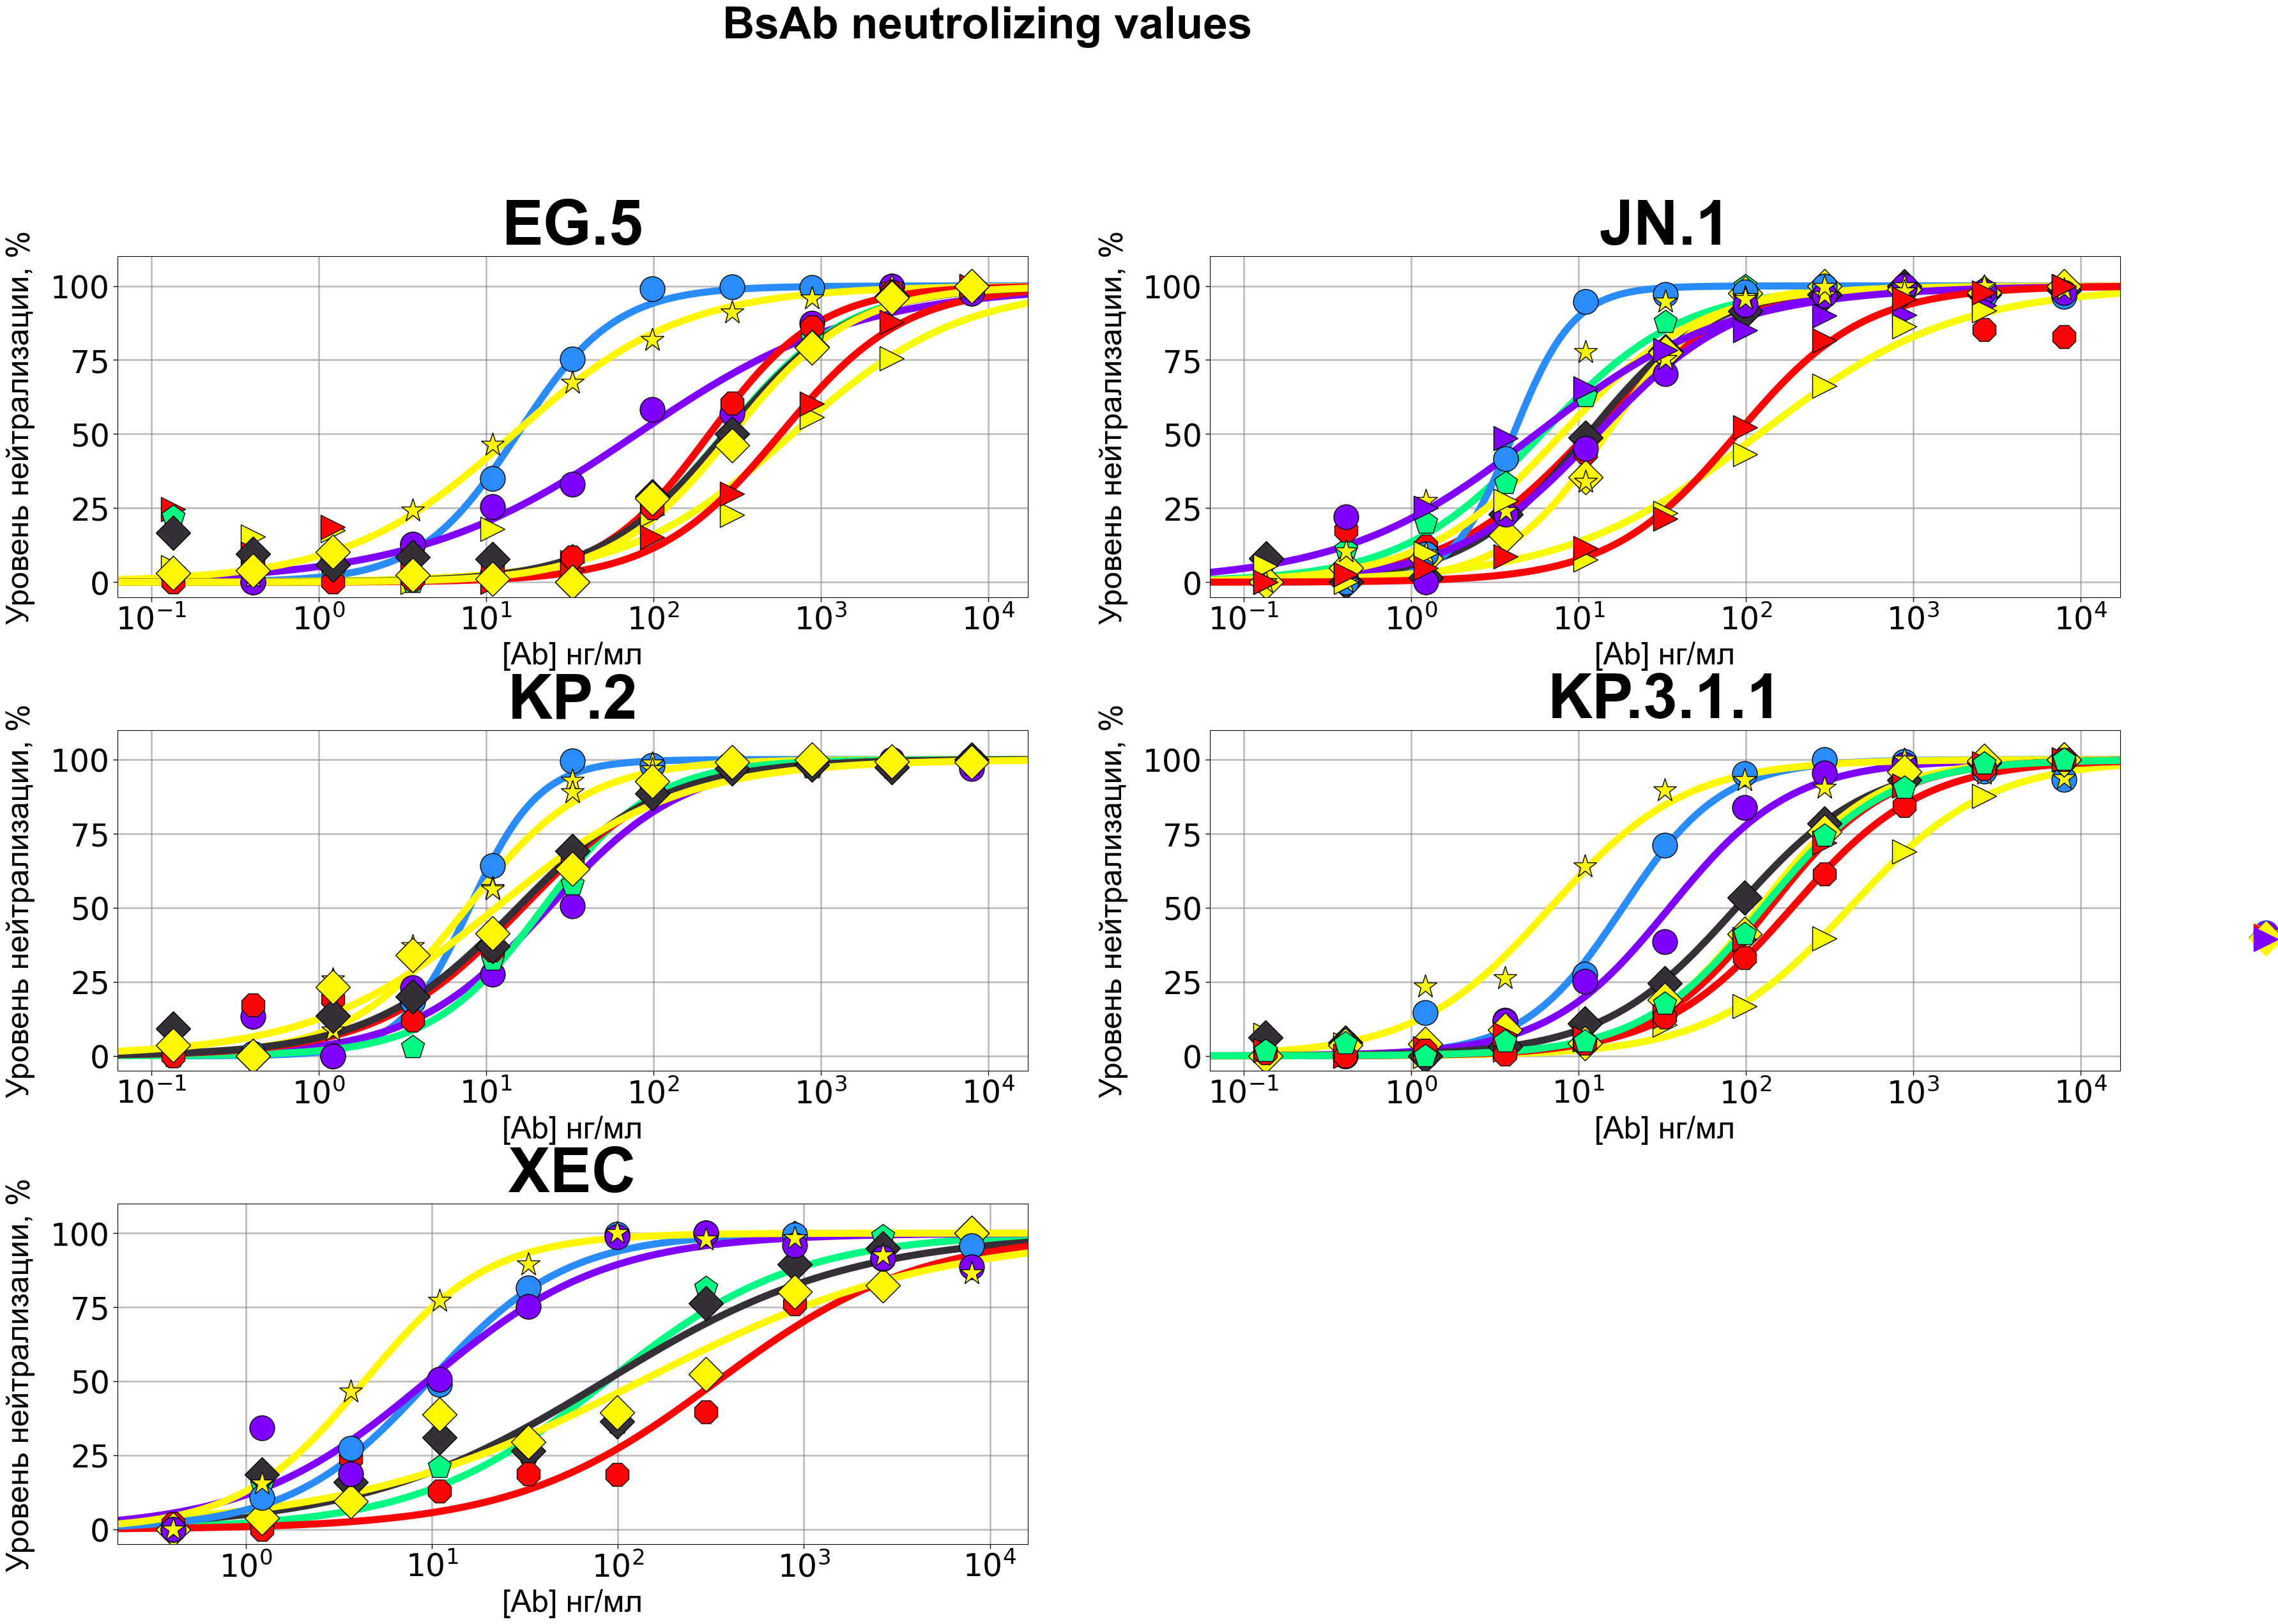

In [16]:
# {'KP2': {'B7+A57-new': True,
#   'SA55': True,
#   'A7+B58-new': True,
#   'glVRC01': True,
#   '80-35-7': True,
#   'KiH-7-57': True,
#   'KiH-57-58': True}}

virus_config = {
    # 'B7+A57': ('#02fa82', '>'),
    # 'A7+B58': ('#b81ff0', '>'),
    # 'A57+B58': ('#353038', '>'),
    # 'KiH-7-57': ('#fa992a', '>'),
    # 'KiH-57-58': ('#353038', '>'),

    # '7': ('#faf32a', 'o'),
    # '21': ('#02fa82', 'o'),
    # '57': ('#fa992a', 'o'),
    # '58': ('#353038', 'o'),  

    # '7-35-L15H': ('#02fa82', 'o'),
    # '57-35-L15H': ('#2a8bfa', 'o'),
    # '58-35-L15H': ('#4d3ef7', 'o'),
    # '7-35-L4H': ('#faf32a', 'o'),
    # '57-35-L4H': ('#02fa82', 'o'),
    # '58-35-L4H': ('#fa992a', 'o'),

    '7-Fc': ('#fa0505', '>'),
    # '21-Fc': ('#02fa82', '>'),
    '57-Fc': ('#7f00ff', '>'),
    '58-Fc': ('#f6fa05', '>'), 

    # '7-21-Fc': ('#b81ff0', 'P'),
    # '7-57-Fc': ('#7f00ff', 'P'),
    # '7-58-Fc': ('#fa2af3', 'P'),
    # '21-57-Fc': ('#353038', 'P'),    
    # '21-58-Fc': ('#fa992a', 'P'),    
    # '57-58-Fc': ('#2a8bfa', 'P'),  

    '7-18-57-Fc': ('#02fa82', 'p'),
    '57-18-7-Fc': ('#2a8bfa', 'o'),
    '58-18-7-Fc': ('#7f00ff', 'o'),
    '58-18-57-Fc': ('#fa0505', '8'),
    '7-35-57-Fc': ('#353038', 'D'),
    '58-35-57-Fc': ('#fff700', 'D'),

    # '7-35-57': ('#faf32a', 'D'),
    # '7-18-57': ('#fa992a', 'D'),
    # '57-18-7': ('#4d3ef7', 'o'),
    # '57-35-7': ('#02fa82', 'o'),
    # '57-18-58': ('#353038', 'o'),
    # '57-35-58': ('#bfb9c4', 'o'),
    # '58-18-7':  ('#2a8bfa', 'o'),
    # '58-35-7':  ('#fff700', 'o'),
    # '58-18-57':  ('#7f00ff', 'o'),
    # '58-35-57': ('#b81ff0', 'P'),
    # '58-N-57': ('#faf32a', 'P'),
    # '58-H2-57': ('#fa992a', 'P'),
    # '58-10-57': ('#fa2af3', 'P'),
    # '80-35-7': ('#02fa82', 'X'),
    # '80-18-57': ('#353038', 'X'),
    # '80-35-57': ('#bfb9c4', 'X'),
    # '80-H-57': ('#2a8bfa', 'X'),
    
    'SA55': ('#fff700', '*'),
    # 'С1': ('#7f00ff', '*'),
    # 'glVRC01': ('#2a8bfa', 'D'),

    # 'KP.3.1.1': ('#02fa82', 'o'),
}

plotData = PlotData(params=dict(
        font="Arial",  # Шрифт для текста на графиках
        markers_colors_dict=virus_config,  # Словарь, содержащий маркеры и цвета для каждого вируса
        title='BsAb neutrolizing values',  # Заголовок графика
        fheight=40,  # Высота фигуры в дюймах
        fwidth=28,  # Ширина фигуры в дюймах
        marker_size=20.,
        marker_size_px=28,  # Размер маркеров в пикселях
        marker_line_px=8,  # Ширина линии маркеров в пикселях
        marker_line_width=10,
        xaxis_coords=(0.5, -0.13),  # Координаты для размещения подписи оси X
        yaxis_coords=(-0.09, 0.5),  # Координаты для размещения подписи оси Y
        xlabel_title_fontsize=35,  # Размер шрифта для подписи оси X
        ylabel_title_fontsize=35,  # Размер шрифта для подписи оси Y
        xlabel_fontsize=35,  # Размер шрифта для меток на оси X
        ylabel_fontsize=35,  # Размер шрифта для меток на оси Y
        xlabel_pad=15,  # Отступ подписи оси X от оси
        ylabel_pad=15,  # Отступ подписи оси Y от оси
        subplot_title_fontsize=70,  # Размер шрифта для заголовков подграфиков
        title_fontsize=50,  # Размер шрифта для общего заголовка графика
        title_padding=0.88,  # Отступ общего заголовка от верхней границы фигуры
        bottom_padding=0.16,
        common_legend=False,
        legend_fontsize=3,  # Размер шрифта для легенды
        legend_borderaxespad=20,  # Отступ легенды от границы фигуры
        legend_ncols=8,  # Количество столбцов в легенде
        xtitle='[Ab] нг/мл',  # Подпись оси X
        ytitle='Уровень нейтрализации, %',  # Подпись оси Y
        wspace=0.2, # расстояние между графиками по горизонтали в масштабе
        hspace=0.39, # расстояние между графиками по вертикали в масштабе
        ncol=2,  # параметр для управления количеством столбцов
        fix_lims={
            'ymin': -5,
            'ymax': 110,
        },
        average_only=True, 
        no_average=False,
        scale=True,
        reverse=True,
        infectivity_or_neutralized='neutralized',
        serum_virus_dict=serum_virus_dict,
))

fig, ax, parsed_df, fit_params = plotData.plotData(
    parsed_dataframe=df,  # DataFrame с данными для построения графиков
)

### Plot legend

In [17]:
new_virus_config = {}
for key, value in virus_config.items():
    new_key = key.replace('-18-', '-GS18-').replace('-35-', '-GS35-').replace('-10-', '-GS10-')
    new_virus_config[new_key] = value

new_virus_config

{'7-Fc': ('#fa0505', '>'),
 '57-Fc': ('#7f00ff', '>'),
 '58-Fc': ('#f6fa05', '>'),
 '7-GS18-57-Fc': ('#02fa82', 'p'),
 '57-GS18-7-Fc': ('#2a8bfa', 'o'),
 '58-GS18-7-Fc': ('#7f00ff', 'o'),
 '58-GS18-57-Fc': ('#fa0505', '8'),
 '7-GS35-57-Fc': ('#353038', 'D'),
 '58-GS35-57-Fc': ('#fff700', 'D'),
 'SA55': ('#fff700', '*')}

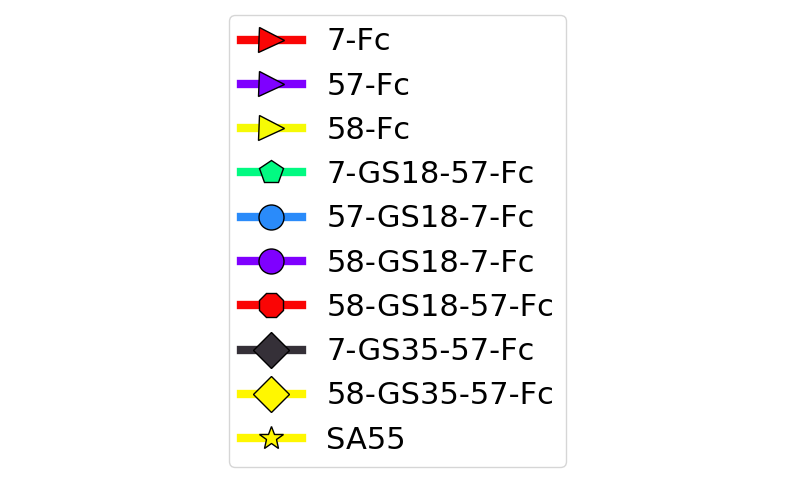

In [20]:
# Создаем фигуру и оси для легенды
fig_legend = plt.figure(figsize=(10, 6))  # Увеличиваем размер фигуры для лучшего отображения
ax_legend = fig_legend.add_subplot(111)
ax_legend.axis('off')  # Отключаем оси

# Создаем прокси-объекты для легенды
handles = []
labels = []
for label, (color, marker) in new_virus_config.items():
    proxy_line = plt.Line2D([0], [0], color=color, marker=marker, linestyle='-', markersize=18, linewidth=6, markeredgewidth=1, markeredgecolor='black')
    handles.append(proxy_line)
    labels.append(label)

# Добавляем легенду на оси с двумя строками
ax_legend.legend(handles, labels, loc='center', fontsize=22, ncol=1, labelspacing=0.5)

# Выводим фигуру с легендой
plt.show()

# Plot Heatmap

In [23]:
midpoints = round(fit_params[['serum', 'virus', 'midpoint', 'r2', 'rmsd']], 3)
dfs = []
for serum in set(fit_params['serum']):
    grouped = fit_params[fit_params['serum'] == serum][['serum', 'virus', 'midpoint']].groupby('virus', as_index=False).agg({'midpoint': 'mean'})
    grouped['serum'] = serum
    dfs.append(grouped)

# Объединяем все датафреймы в один
combined_df = pd.concat(dfs, ignore_index=True)

# Преобразуем объединенный датафрейм в матрицу
matrix_df = round(combined_df.pivot(index='serum', columns='virus', values='midpoint').T, 2)
matrix_df = matrix_df.T.rename(
    columns={
        '7-18-57-Fc': '7-GS18-57-Fc', 
        '58-18-57-Fc': '58-GS18-57-Fc', 
        '7-35-57-Fc': '7-GS35-57-Fc', 
        '58-35-57-Fc': '58-GS35-57-Fc',
        '57-18-7-Fc': '57-GS18-7-Fc',
        '58-18-7-Fc': '58-GS18-7-Fc',
        '7-18-57': '7-GS18-57', 
        '7-35-57': '7-GS35-57', 
        '57-18-7': '57-GS18-7', 
        '57-35-7': '57-GS35-7', 
        '57-18-58': '57-GS18-58', 
        '57-35-58': '57-GS35-58', 
        '58-18-7': '58-GS18-7', 
        '58-35-7': '58-GS35-7', 
        '58-10-57': '58-GS10-57', 
        '58-18-57': '58-GS18-57', 
        '58-35-57': '58-GS35-57', 
        '80-35-7': '80-GS35-7', 
        '80-18-57': '80-GS18-57', 
        '80-35-57': '80-GS35-57', 
        '7-35-L15H': '7-GS35-L15H', 
        '57-35-L15H': '57-GS35-L15H', 
        '58-35-L15H': '58-GS35-L15H',
        }
    )

column_order = [
    # '7', '57', '58', 
    '7-Fc', '57-Fc', '58-Fc', 
    # '7-57-Fc', '7-58-Fc', '57-58-Fc', 
    '7-GS18-57-Fc', '58-GS18-57-Fc', '7-GS35-57-Fc', '58-GS35-57-Fc', 
    '57-GS18-7-Fc', '58-GS18-7-Fc',
    # '7-GS18-57', '7-GS35-57', '57-GS18-7', '57-GS35-7', '57-GS18-58', '57-GS35-58', '58-GS18-7', '58-GS35-7', '58-GS10-57', 
    # '58-GS18-57', '58-GS35-57', '58-N-57', '58-H2-57',  '80-GS35-7', 
    # '7-GS35-L15H', '57-GS35-L15H', '58-GS35-L15H',
    'SA55', 
    ]

# column_order = [
#     '7-GS18-57-Fc', '58-GS18-57-Fc', '7-GS35-57-Fc', '58-GS35-57-Fc', '57-GS18-7-Fc', '58-GS18-7-Fc',
#     'SA55',
#     ]

matrix_df = matrix_df.reindex(columns=column_order, index=['EG.5', 'JN.1', 'KP.2', 'KP.3.1.1'])
# matrix_df = matrix_df.reindex(columns=column_order) # для KiH
# matrix_df.to_excel('heatmap_ic50_matrix.xlsx')
# matrix_df.loc['SARS1', '58-57-Gs35'] = 0

# matrix_df.loc['SARS1', '57'] = None
# matrix_df.loc['EG.5', '57-Fc'] = None
for column in matrix_df.columns:
    matrix_df[column] = matrix_df[column].apply(lambda x: float("{:.2f}".format(x)))
matrix_df

virus,7-Fc,57-Fc,58-Fc,7-GS18-57-Fc,58-GS18-57-Fc,7-GS35-57-Fc,58-GS35-57-Fc,57-GS18-7-Fc,58-GS18-7-Fc,SA55
serum,,,,,,,,,,
EG.5,574.10,NaN,677.83,266.14,216.75,269.75,294.35,15.43,79.77,14.69
JN.1,88.48,5.59,120.30,6.03,11.34,11.45,14.66,4.08,12.86,7.93
KP.2,NaN,NaN,NaN,22.05,16.56,15.46,11.50,7.98,23.68,7.73
KP.3.1.1,138.60,NaN,418.61,126.89,189.04,88.00,120.40,18.44,35.04,6.80


In [26]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm, rgb2hex
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def heatmap(
        matrix_df,
        name,
        colors,
        xrot=0,
        decimals=".2f",
        height=16,
        weight=9,
        title_padding=20,
        ):
    # Создаем пользовательскую цветовую палитру с заданными позициями для каждого цвета
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color for _, color in colors])

    # Преобразование DataFrame в массив numpy для использования в matplotlib
    data_array = matrix_df.to_numpy()

    # Создаем heatmap
    fig, ax = plt.subplots(figsize=(height, weight))

    # Устанавливаем шрифт Arial
    plt.rcParams['font.family'] = 'Arial'

    # Построение тепловой карты с логарифмической шкалой
    norm = LogNorm(vmin=matrix_df.min().min(), vmax=matrix_df.max().max())
    img = plt.imshow(data_array, cmap=cmap, norm=norm, aspect='auto')

    # Функция для определения яркости цвета
    def get_brightness(color):
        r, g, b = color[:3]  # Извлекаем компоненты RGB
        brightness = (r * 299 + g * 587 + b * 114) / 1000  # Вычисляем яркость
        return brightness

    # Добавление аннотаций
    for i in range(data_array.shape[0]):
        for j in range(data_array.shape[1]):
            value = data_array[i, j]
            # annot_value = '<1' if pd.notna(value) and value < 1 else f'{value:{decimals}}'
            annot_value = f'{value:{decimals}}'

            # Получаем цвет ячейки
            color = img.cmap(img.norm(value))
            brightness = get_brightness(color)

            # Выбираем цвет текста в зависимости от яркости фона
            text_color = 'black' if brightness > 0.5 else 'white'

            plt.annotate(annot_value, xy=(j, i), ha='center', va='center', color=text_color, fontsize=30, fontweight='bold', fontfamily='Arial')

    # Добавление границ между ячейками
    for i in range(data_array.shape[0] + 1):
        plt.hlines(y=i - 0.5, xmin=-0.5, xmax=data_array.shape[1] - 0.5, color='gray', linewidth=0.5)
    for j in range(data_array.shape[1] + 1):
        plt.vlines(x=j - 0.5, ymin=-0.5, ymax=data_array.shape[0] - 0.5, color='gray', linewidth=0.5)

    # Добавление цветовой шкалы
    cbar = plt.colorbar(ticks=np.logspace(np.log10(matrix_df.min().min()), np.log10(matrix_df.max().max()), num=5))
    cbar.ax.set_yticklabels([f'{tick:.2e}' for tick in cbar.get_ticks()])
    cbar.set_label('IC50 (ng/ml)', fontsize=32, fontweight='bold', fontfamily='Arial')
    cbar.ax.tick_params(labelsize=20, labelcolor='black')

    # Установка заголовка и меток осей
    plt.title('IC50 (ng/ml)', fontsize=50, fontweight='bold', fontfamily='Arial', pad=title_padding)
    plt.xlabel('Antibody', fontsize=35, fontweight='bold', fontfamily='Arial')
    plt.ylabel('Virus', fontsize=35, fontweight='bold', fontfamily='Arial')
    plt.xticks(ticks=np.arange(data_array.shape[1]), labels=matrix_df.columns, rotation=xrot, ha='right', fontsize=30, fontweight='bold', fontfamily='Arial')
    plt.yticks(ticks=np.arange(data_array.shape[0]), labels=matrix_df.index, fontsize=32, fontweight='bold', fontfamily='Arial')

    return fig


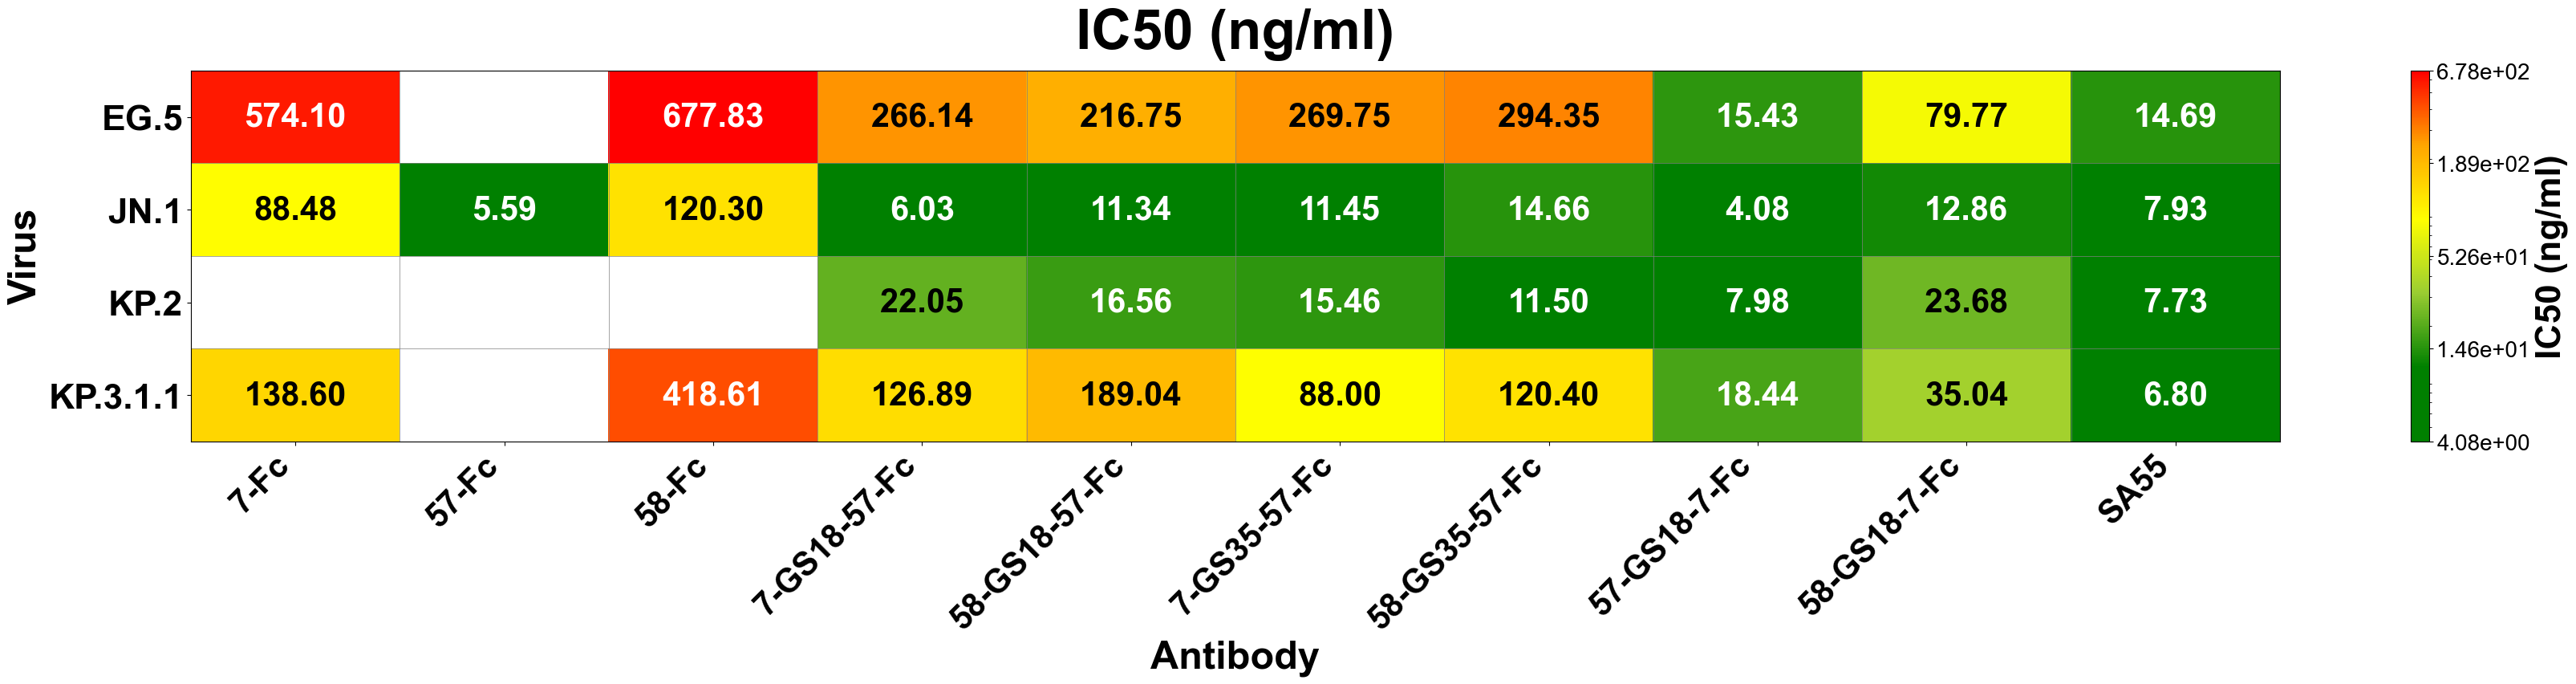

In [27]:
hmap = heatmap(
    matrix_df=matrix_df, 
    xrot=45, 
    # xpad=10,
    name='bivalents_ic50.png', 
    decimals=".2f",
    colors = [
        (0, 'green'),
        (0.3, 'green'),  # Желтый до 1000
        (0.9, 'yellowgreen'),
        (0.99, 'yellow'),
        (0.99, 'orange'),
        (1, 'red')  # Красный
    ],
    height=42,
    weight=6,
    title_padding=20,
    )

In [30]:
# Weight in kDa

sa55_weight = 1.5e5
glVrc01_weight = 1.5e5

In [33]:
ab_sequences = {
    # "7-Fc": "AMINO-ACID SEQUENCE",
    "57-Fc": "AGRAHSYSTAGA",
}

In [35]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pint

def calculate_molecular_weights(ab_sequences):
    # Создаем объект UnitRegistry
    ureg = pint.UnitRegistry()

    # Создаем пустой словарь для хранения молекулярных весов
    molecular_weights = {}

    # Проходим по каждой последовательности в словаре
    for name, sequence in ab_sequences.items():
        # Создаем объект ProteinAnalysis для анализа последовательности
        analysed_protein = ProteinAnalysis(sequence)

        # Вычисляем молекулярный вес белка
        molecular_weight = analysed_protein.molecular_weight()

        # Добавляем молекулярный вес в словарь
        molecular_weights[name] = molecular_weight

    return molecular_weights

ab_weights = calculate_molecular_weights(ab_sequences)
ab_weights['SA55'] = sa55_weight
ab_weights

{'57-Fc': 1148.1861999999999, 'SA55': 150000.0}

In [39]:
def calculate_concentrations(ab_weights, midpoints_df):
    # Создаем объект UnitRegistry
    ureg = pint.UnitRegistry()

    # Создаем пустой список для хранения концентраций в нМ
    concentrations_nM = []
    # concentrations_nM_corrected = []

    # Проходим по каждой строке в датафрейме
    for index, row in midpoints_df.iterrows():
        virus = row['serum']
        midpoint_ng_ml = row['midpoint']
        # midpoint_corrected_ng_ml = row['midpoint_corrected']

        # Получаем молекулярный вес из словаря
        molecular_weight = ab_weights.get(virus)

        if molecular_weight is not None:
            # Переводим концентрацию в нМ
            concentration_nM = (midpoint_ng_ml * ureg.ng / ureg.ml) / (molecular_weight * ureg.g / ureg.mol)
            concentration_nM = concentration_nM.to(ureg.nanomolar)
            concentrations_nM.append(concentration_nM.magnitude)

            # concentration_nM_corrected = (midpoint_corrected_ng_ml * ureg.ng / ureg.ml) / (molecular_weight * ureg.g / ureg.mol)
            # concentration_nM_corrected = concentration_nM_corrected.to(ureg.nanomolar)
            # concentrations_nM_corrected.append(concentration_nM_corrected.magnitude)
        else:
            # Если молекулярный вес не найден, добавляем NaN
            concentrations_nM.append(float('nan'))
            # concentrations_nM_corrected.append(float('nan'))

    # Добавляем новую колонку с концентрациями в нМ в датафрейм
    midpoints_df['concentration_nM'] = concentrations_nM
    # midpoints_df['concentrations_nM_corrected'] = concentrations_nM_corrected

    return midpoints_df

result_df = calculate_concentrations(ab_weights, midpoints)
result_df = result_df[["serum", "virus", "midpoint", "r2", "rmsd", "concentration_nM"]]
result_df # is empty because we can't reveal sequences

,serum,virus,midpoint,r2,rmsd,concentration_nM
0,EG.5,57-18-7-Fc,15.432,0.994,3.119,NaN
1,EG.5,58-18-7-Fc,79.775,0.973,5.868,NaN
2,EG.5,SA55,14.687,0.997,2.268,NaN
3,EG.5,58-Fc,677.834,0.898,9.768,NaN
4,EG.5,7-Fc,574.104,0.905,10.153,NaN
5,EG.5,7-18-57-Fc,266.145,0.964,7.120,NaN
6,EG.5,58-18-57-Fc,216.755,0.996,2.396,NaN
7,EG.5,7-35-57-Fc,269.747,0.959,7.409,NaN
8,EG.5,58-35-57-Fc,294.354,0.984,4.794,NaN
9,JN.1,7-18-57-Fc,6.034,0.993,3.248,NaN


In [40]:
matrix_df = result_df.pivot(index='serum', columns='virus', values='concentration_nM')
matrix_df = matrix_df.T.rename(
    columns={
        '7-18-57-Fc': '7-GS18-57-Fc', 
        '58-18-57-Fc': '58-GS18-57-Fc', 
        '7-35-57-Fc': '7-GS35-57-Fc', 
        '58-35-57-Fc': '58-GS35-57-Fc',
        '57-18-7-Fc': '57-GS18-7-Fc',
        '58-18-7-Fc': '58-GS18-7-Fc',
        '7-18-57': '7-GS18-57', 
        '7-35-57': '7-GS35-57', 
        '57-18-7': '57-GS18-7', 
        '57-35-7': '57-GS35-7', 
        '57-18-58': '57-GS18-58', 
        '57-35-58': '57-GS35-58', 
        '58-18-7': '58-GS18-7', 
        '58-35-7': '58-GS35-7', 
        '58-10-57': '58-GS10-57', 
        '58-18-57': '58-GS18-57', 
        '58-35-57': '58-GS35-57', 
        '80-35-7': '80-GS35-7', 
        '80-18-57': '80-GS18-57', 
        '80-35-57': '80-GS35-57', 
        '7-35-L15H': '7-GS35-L15H', 
        '57-35-L15H': '57-GS35-L15H', 
        '58-35-L15H': '58-GS35-L15H',
        }
    )
column_order = [
    # '7', '57', '58', 
    '7-Fc', '57-Fc', '58-Fc', 
    # '7-57-Fc', '7-58-Fc', '57-58-Fc', 
    # '7-GS18-57-Fc', '58-GS18-57-Fc', '7-GS35-57-Fc', '58-GS35-57-Fc', 
    # '57-GS18-7-Fc', '58-GS18-7-Fc',
    '7-GS18-57', '7-GS35-57', '57-GS18-7', '57-GS35-7', '57-GS18-58', '57-GS35-58', '58-GS18-7', '58-GS35-7', '58-GS10-57', 
    '58-GS18-57', '58-GS35-57', '58-N-57', '58-H2-57',  '80-GS35-7', 
    # '7-GS35-L15H', '57-GS35-L15H', '58-GS35-L15H',
    'SA55', 
    ]

# column_order = [
#     '7-GS18-57-Fc', '58-GS18-57-Fc', '7-GS35-57-Fc', '58-GS35-57-Fc', '57-GS18-7-Fc', '58-GS18-7-Fc',
#     'SA55',
#     ]
matrix_df = matrix_df.reindex(columns=column_order)
for column in matrix_df.columns:
    matrix_df[column] = matrix_df[column].apply(lambda x: float("{:.2f}".format(x)))

matrix_df

serum,7-Fc,57-Fc,58-Fc,7-GS18-57,7-GS35-57,57-GS18-7,57-GS35-7,57-GS18-58,57-GS35-58,58-GS18-7,58-GS35-7,58-GS10-57,58-GS18-57,58-GS35-57,58-N-57,58-H2-57,80-GS35-7,SA55
virus,,,,,,,,,,,,,,,,,,
57-18-7-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58-18-57-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58-18-7-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58-35-57-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-18-57-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-35-57-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
